## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Load Dataset

In [165]:
raw_data = pd.read_csv("Online_Retail.csv")
# ,parse_dates=['InvoiceDate']
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


## Convert to Time series data

In [230]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
# sales_data=sales_data.set_index(['InvoiceDate'])
sales_data.info()
sales_data.index
# sales_data.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB


RangeIndex(start=0, stop=541909, step=1)

In [189]:
# dates = sales_data.drop(['StockCode','Quantity'],axis =1)
# dates['InvoiceDate'] = pd.to_datetime(dates['InvoiceDate'])
# dates['InvoiceDate'] = dates['InvoiceDate'].dt.date

,InvoiceDate
0,2010-01-12
1,2010-01-12
2,2010-01-12
3,2010-01-12
4,2010-01-12


In [196]:
# (dates.InvoiceDate.min(),dates.InvoiceDate.max())
# dates.head()

(datetime.date(2010, 1, 12), datetime.date(2011, 12, 10))

### Extracting one product out

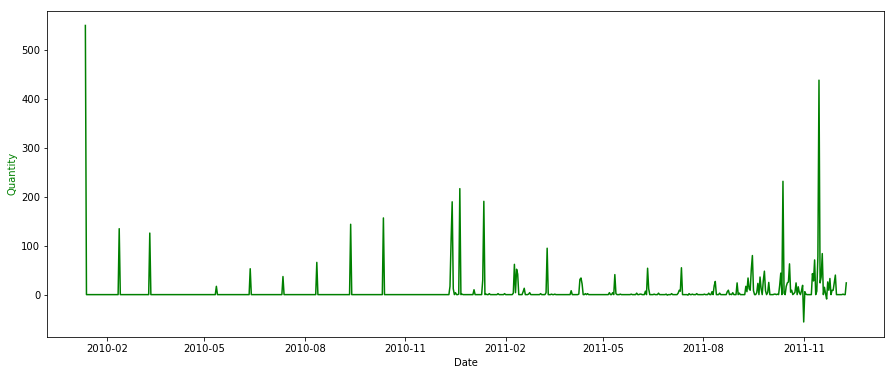

In [264]:
#pull out all transactions of one product and drop StockCode
product = sales_data.loc[sales_data['StockCode'] == '84029E'].drop('StockCode',axis=1)
product=product.set_index(['InvoiceDate']) #Convert to timeseries 

#DownSampling to a day
day_summary = pd.DataFrame()
day_summary['Quantity'] = product.Quantity.resample('D').sum()
day_summary = day_summary.fillna(0) 


# print((product.index.max(),product.index.min()))
# product.Date.nunique()

day_summary.head(10)
# day_summary.loc[day_summary['Quantity'] != 0]






fig, ax1 = plt.subplots()
ax1.plot(day_summary.index, day_summary['Quantity'], 'g-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quantity', color='g')
plt.show()